#   IAU Zadanie - II. fáza

### Autori: Peter Brandajsky - 50%, Frederik Duvač - 50%

# Načítanie údajov z datasetu

Dataset sme si exportli, nakonci fázy 1, kde sme spojili **connections_mean_median** a **processes_mean_median** na **imei** a **ts** stĺpcoch, čo boli naše upravené datasety s imputáciou missing values.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

dataset = pd.read_csv('dataset/dataset_phase_2.csv', sep='\t')

In [29]:
dataset.head()

,ts,imei,mwra,c.android.gm,c.android.chrome,c.dogalize,c.katana,c.android.youtube,c.android.vending,c.updateassist,...,p.process.gapps,p.katana,p.gms.persistent,p.android.defcontainer,p.browser.provider,p.simulator,p.notifier,p.android.vending,p.dogalize,p.android.gms
0,2018-05-05 10:00:00,3590433799317661479,0.0,7.58999,10.10690,13.15797,9.38358,12.97598,36.79370,52.292355,...,31.46173,75.73633,17.18109,28.63863,86.03245,87.66743,22.50267,62.67423,85.26363,47.83375
1,2018-05-05 10:01:00,3590433799317661115,1.0,13.90744,11.08136,10.56072,11.35434,13.32609,45.54295,25.353440,...,57.78407,88.65165,0.35403,37.70733,50.73157,22.83300,20.08413,45.59394,42.29871,32.98469
2,2018-05-05 10:02:00,359043379931766155,0.0,12.07737,9.28159,11.69018,9.33765,13.66042,31.33313,57.102670,...,39.65381,80.18738,92.40107,69.92029,58.19673,77.88785,71.49623,9.73326,12.17514,79.96124
3,2018-05-05 10:03:00,3590433799317661040,0.0,11.93742,9.87723,14.49817,10.41657,15.17780,32.24723,67.041760,...,47.65908,65.78662,8.17850,21.81412,28.87156,70.59531,19.30408,28.30924,85.76963,90.10998
4,2018-05-05 10:04:00,8630330696303481669,1.0,7.91094,14.34135,11.03992,16.50329,7.84216,63.95286,65.506340,...,47.05190,32.27816,35.86468,93.24048,16.82238,3.86695,19.23138,72.90849,75.26363,81.45468


Atributy pri ktorých nebola ziadna korelacia, sme kompletne vyradili do dalsej manipulacie s datasetom.

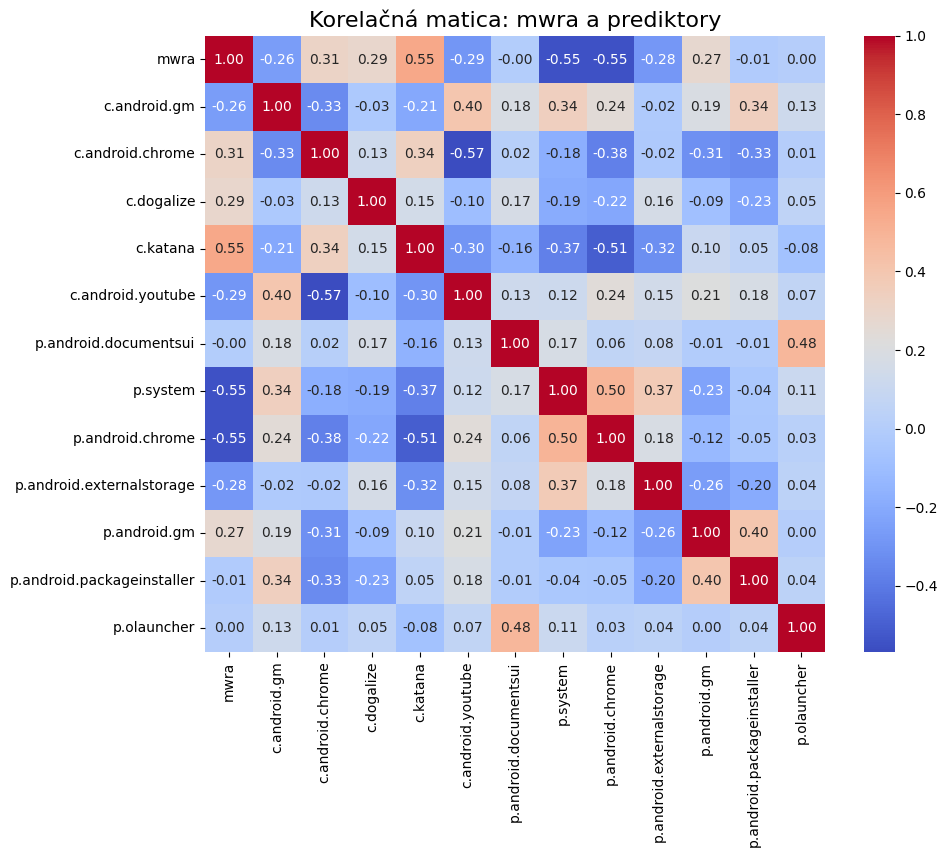

In [30]:
dataset = dataset[
    ['mwra', 'c.android.gm', 'c.android.chrome', 'c.dogalize', 'c.katana', 'c.android.youtube', 'p.android.documentsui',
     'p.system', 'p.android.chrome', 'p.android.externalstorage',
     'p.android.gm', 'p.android.packageinstaller', 'p.olauncher']]

plt.figure(figsize=(10, 8))
sns.heatmap(dataset.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Korelačná matica: mwra a prediktory', fontsize=16)
plt.show()

In [31]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14884 entries, 0 to 14883
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   mwra                        14884 non-null  float64
 1   c.android.gm                14884 non-null  float64
 2   c.android.chrome            14884 non-null  float64
 3   c.dogalize                  14884 non-null  float64
 4   c.katana                    14884 non-null  float64
 5   c.android.youtube           14884 non-null  float64
 6   p.android.documentsui       14884 non-null  float64
 7   p.system                    14884 non-null  float64
 8   p.android.chrome            14884 non-null  float64
 9   p.android.externalstorage   14884 non-null  float64
 10  p.android.gm                14884 non-null  float64
 11  p.android.packageinstaller  14884 non-null  float64
 12  p.olauncher                 14884 non-null  float64
dtypes: float64(13)
memory usage: 1.

# 2.1 Realizácia predspracovania dát

## 2.1.A

In [32]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(
    dataset,
    test_size=0.2,
    random_state=42,
    stratify=dataset['mwra']  # Toto zabezpečí rovnakú distribúciu tried
)

# Kontrola distribúcie tried
print("Kontrola distribúcie tried:\n")
print("Pôvodný dataset:")
print(dataset['mwra'].value_counts(normalize=True).round(6))

print("\nTrénovacia množina:")
print(train_data['mwra'].value_counts(normalize=True).round(6))

print("\nTestovacia množina:")
print(test_data['mwra'].value_counts(normalize=True).round(6))

# Kontrola absolútnych počtov
print("\nAbsolútne počty:")
print(f"Celkový počet vzoriek: {len(dataset)}")
print(f"Počet trénovacích vzoriek: {len(train_data)} ({len(train_data)/len(dataset)*100:.1f}%)")
print(f"Počet testovacích vzoriek: {len(test_data)} ({len(test_data)/len(dataset)*100:.1f}%)")

Kontrola distribúcie tried:

Pôvodný dataset:
mwra
1.0    0.626512
0.0    0.373488
Name: proportion, dtype: float64

Trénovacia množina:
mwra
1.0    0.626522
0.0    0.373478
Name: proportion, dtype: float64

Testovacia množina:
mwra
1.0    0.62647
0.0    0.37353
Name: proportion, dtype: float64

Absolútne počty:
Celkový počet vzoriek: 14884
Počet trénovacích vzoriek: 11907 (80.0%)
Počet testovacích vzoriek: 2977 (20.0%)


## 2.1.B

#### Kontrola formátu dát

In [33]:
print(f"Počet pozorovaní (riadkov): {len(train_data)}")
print(f"Počet atribútov (stĺpcov): {len(train_data.columns)}")
print("\nTypy dát v stĺpcoch:")
print(train_data.dtypes)

Počet pozorovaní (riadkov): 11907
Počet atribútov (stĺpcov): 13

Typy dát v stĺpcoch:
mwra                          float64
c.android.gm                  float64
c.android.chrome              float64
c.dogalize                    float64
c.katana                      float64
c.android.youtube             float64
p.android.documentsui         float64
p.system                      float64
p.android.chrome              float64
p.android.externalstorage     float64
p.android.gm                  float64
p.android.packageinstaller    float64
p.olauncher                   float64
dtype: object


Vidime ze vsetky data mame numericke takze nepotrebujeme robit ziaden encoding.

#### Kontrola chýbajúcich hodnôt

In [34]:
print("\nKontrola chýbajúcich hodnôt:")
missing_values = train_data.isnull().sum()
print(missing_values)

if missing_values.any():
    print("\nNahradzovanie chýbajúcich hodnôt:")
    # Pre numerické stĺpce použijeme medián
    numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_columns:
        if missing_values[col] > 0:
            median_value = train_data[col].median()
            train_data[col].fillna(median_value, inplace=True)
            print(f"Stĺpec {col}: nahradených {missing_values[col]} hodnôt mediánom")


Kontrola chýbajúcich hodnôt:
mwra                          0
c.android.gm                  0
c.android.chrome              0
c.dogalize                    0
c.katana                      0
c.android.youtube             0
p.android.documentsui         0
p.system                      0
p.android.chrome              0
p.android.externalstorage     0
p.android.gm                  0
p.android.packageinstaller    0
p.olauncher                   0
dtype: int64


Dataset neobsahuje ziadne chybajuce hodnoty

#### Kontrola a spracovanie outlierov pomocou IQR



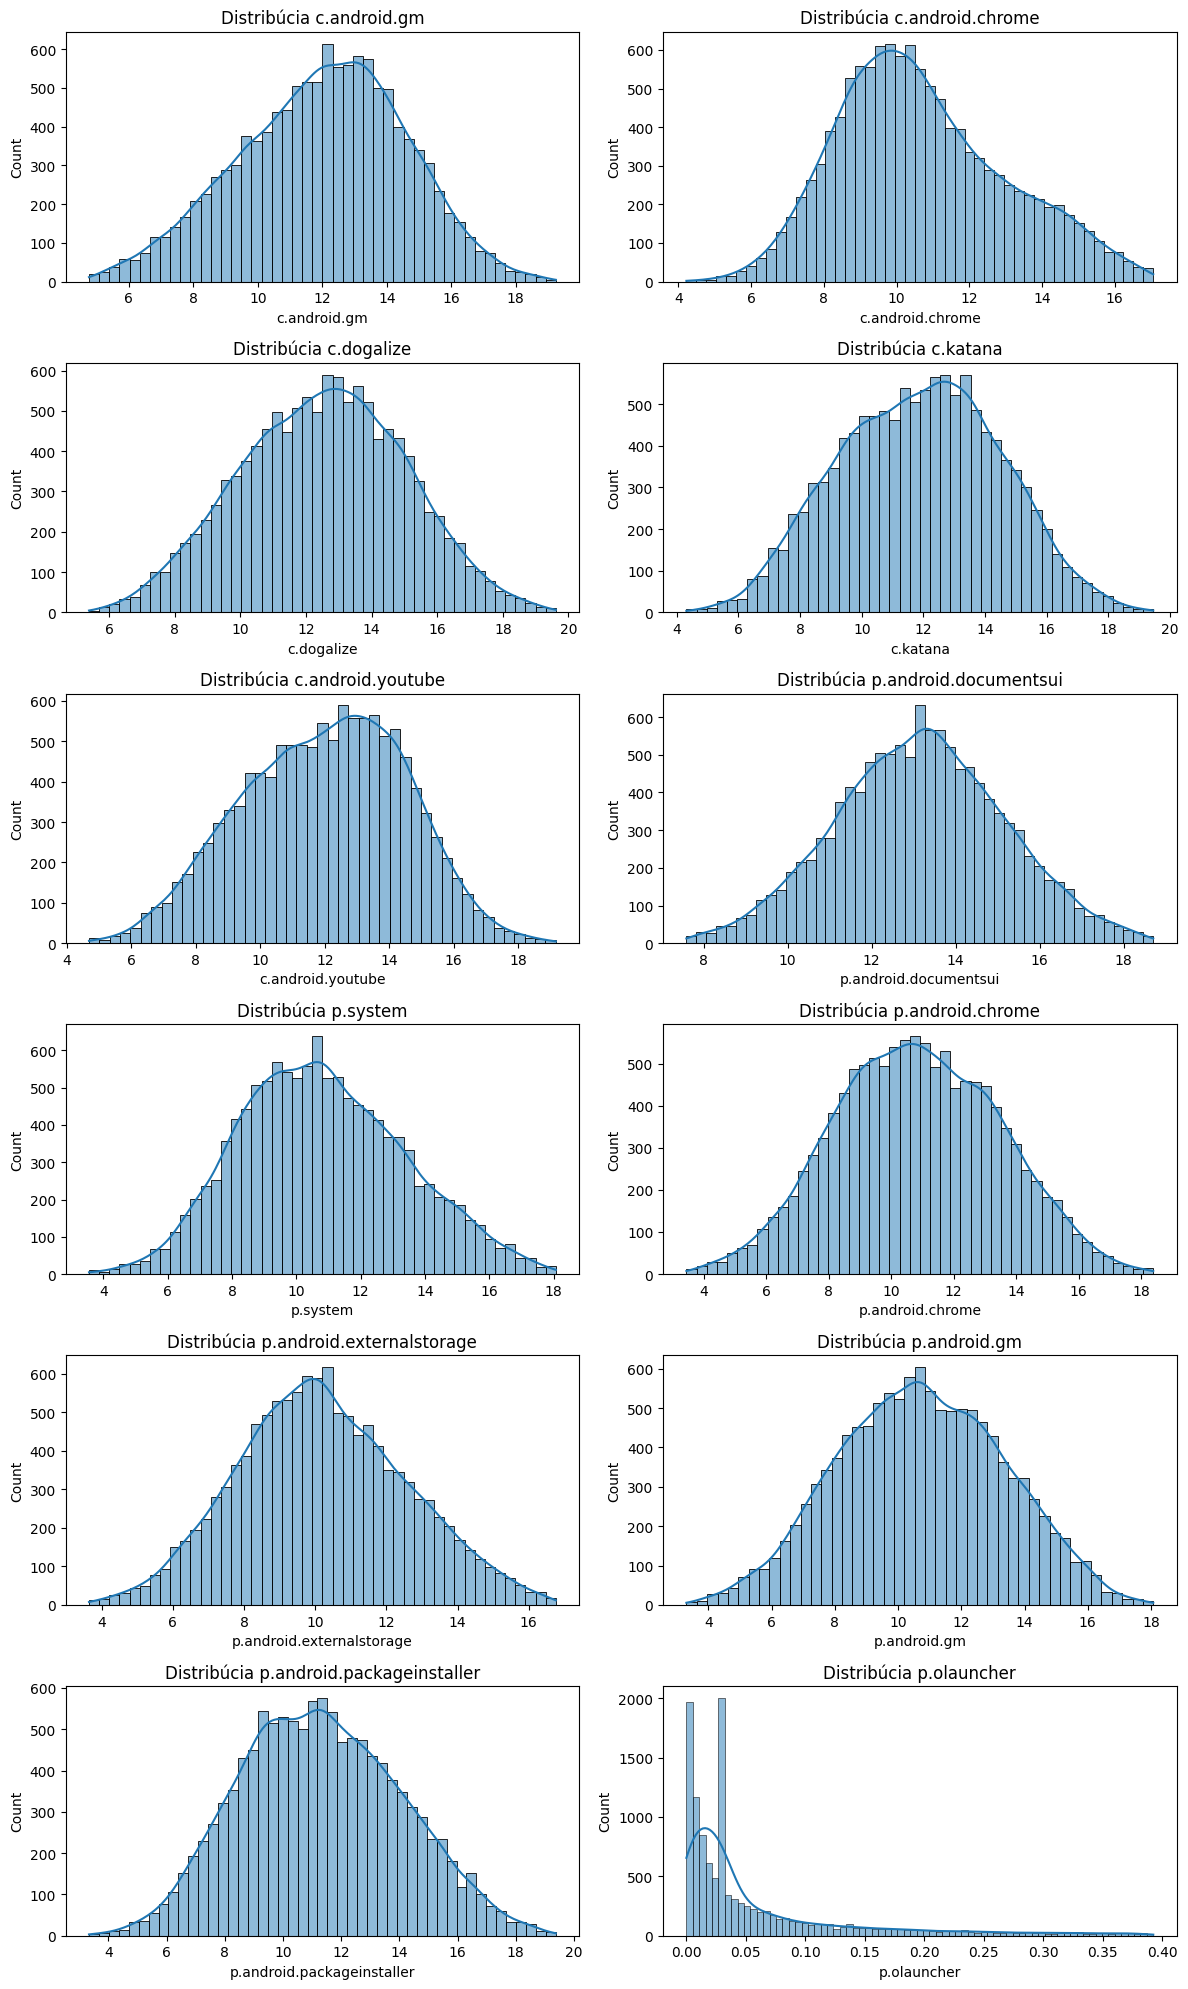

In [35]:
# Získanie počtu stĺpcov, ktoré chceme vizualizovať
num_columns = len(train_data.drop('mwra', axis=1).columns)

# Dynamické nastavenie počtu riadkov a stĺpcov pre mriežku grafov
cols = 2
rows = np.ceil(num_columns / cols).astype(int)  # zaokrúhlenie nahor

plt.figure(figsize=(12, 20))
for i, column in enumerate(train_data.drop('mwra', axis=1).columns):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(data=train_data, x=column, kde=True)
    plt.title(f'Distribúcia {column}')
plt.tight_layout()
plt.show()

V prvej faze sme risili odstraneni outlierov a nahradenie nan hodnot priemerom alebo medianom. Data po rozdeleni ukazuju nejakych outlierov tak ich nahradime technikou winsorization, cize hranicnymi hodnotami.

In [36]:
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Počet outlierov
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    print(f"\nStĺpec {column}:")
    print(f"Počet outlierov: {len(outliers)}")
    print(f"Percento outlierov: {(len(outliers)/len(df)*100):.2f}%")
    
    # Nahradenie outlierov hraničnými hodnotami
    df.loc[df[column] < lower_bound, column] = lower_bound
    df.loc[df[column] > upper_bound, column] = upper_bound
    
    return df

# Spracovanie outlierov pre každý numerický stĺpec okrem target premennej
print("\nSpracovanie outlierov:")
for column in train_data.select_dtypes(include=['float64', 'int64']).columns:
    if column != 'mwra': 
        train_data = handle_outliers(train_data, column)


print(f"\nPočet riadkov po odstránení outlierov: {len(train_data)}")



Spracovanie outlierov:

Stĺpec c.android.gm:
Počet outlierov: 5
Percento outlierov: 0.04%

Stĺpec c.android.chrome:
Počet outlierov: 15
Percento outlierov: 0.13%

Stĺpec c.dogalize:
Počet outlierov: 0
Percento outlierov: 0.00%

Stĺpec c.katana:
Počet outlierov: 1
Percento outlierov: 0.01%

Stĺpec c.android.youtube:
Počet outlierov: 0
Percento outlierov: 0.00%

Stĺpec p.android.documentsui:
Počet outlierov: 16
Percento outlierov: 0.13%

Stĺpec p.system:
Počet outlierov: 9
Percento outlierov: 0.08%

Stĺpec p.android.chrome:
Počet outlierov: 0
Percento outlierov: 0.00%

Stĺpec p.android.externalstorage:
Počet outlierov: 4
Percento outlierov: 0.03%

Stĺpec p.android.gm:
Počet outlierov: 0
Percento outlierov: 0.00%

Stĺpec p.android.packageinstaller:
Počet outlierov: 3
Percento outlierov: 0.03%

Stĺpec p.olauncher:
Počet outlierov: 1325
Percento outlierov: 11.13%

Počet riadkov po odstránení outlierov: 11907


#### Kontrola vyslednych dat


Kontrola výsledných dát:

Základné štatistiky:
               mwra  c.android.gm  c.android.chrome    c.dogalize  \
count  11907.000000  11907.000000      11907.000000  11907.000000   
mean       0.626522     11.996285         10.689890     12.519524   
std        0.483748      2.581128          2.321027      2.510432   
min        0.000000      4.829978          4.240908      5.383470   
25%        0.000000     10.229160          9.007735     10.733620   
50%        1.000000     12.133630         10.386155     12.573610   
75%        1.000000     13.828615         12.185620     14.312125   
max        1.000000     19.227797         16.952447     19.616710   

           c.katana  c.android.youtube  p.android.documentsui      p.system  \
count  11907.000000       11907.000000           11907.000000  11907.000000   
mean      11.892934          11.989846              13.163467     10.809804   
std        2.610355           2.509408               2.015398      2.568229   
min        4.3

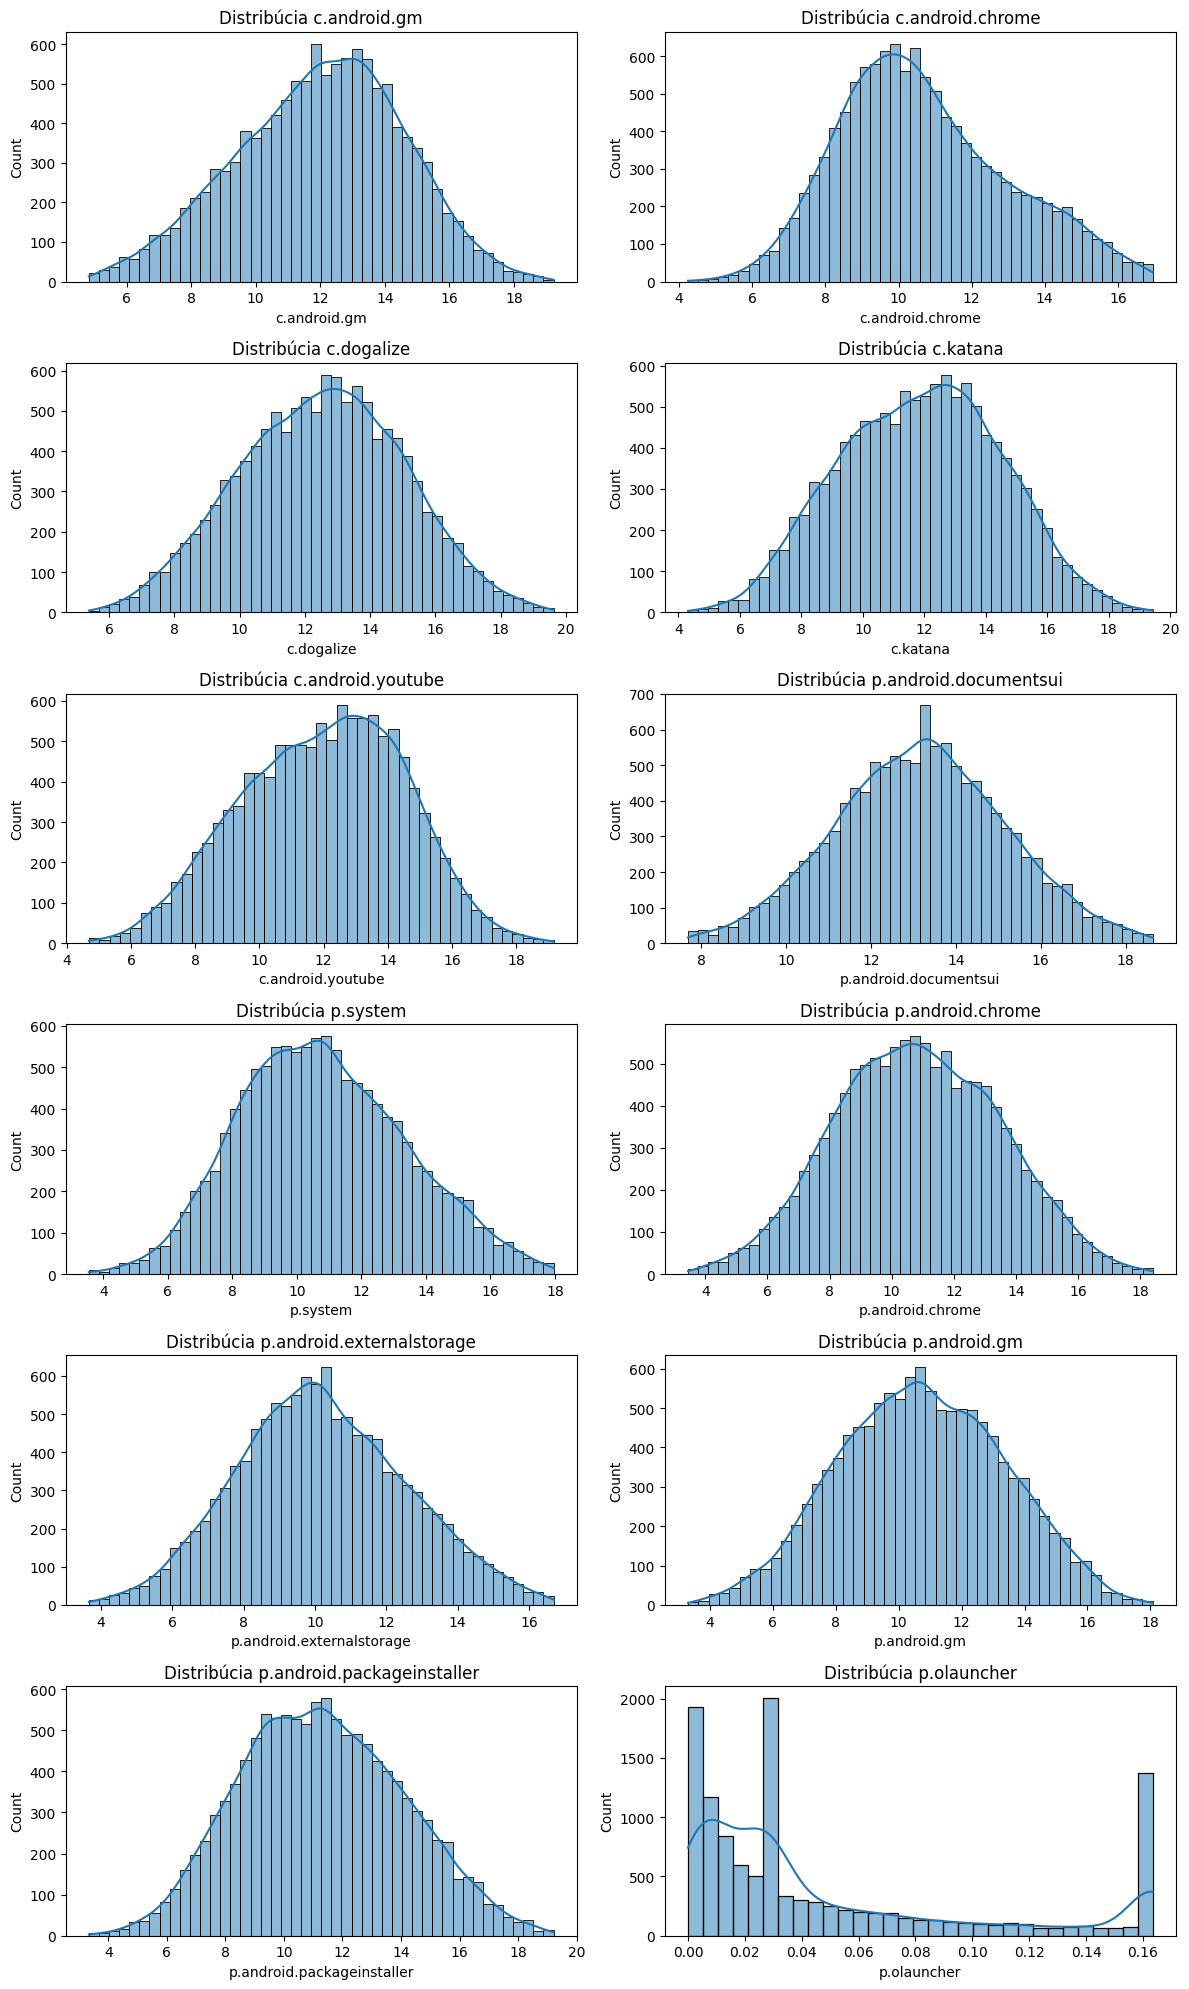

In [37]:
print("\nKontrola výsledných dát:")
print("\nZákladné štatistiky:")
print(train_data.describe())

print("\nKontrolné body:")
print(f"- Počet pozorovaní (riadkov): {len(train_data)}")
print(f"- Počet atribútov (stĺpcov): {len(train_data.columns)}")
print("- Všetky atribúty sú numerické:", all(train_data.dtypes.apply(lambda x: np.issubdtype(x, np.number))))
print("- Žiadne chýbajúce hodnoty:", not train_data.isnull().any().any())

# Získanie počtu stĺpcov, ktoré chceme vizualizovať
num_columns = len(train_data.drop('mwra', axis=1).columns)

# Dynamické nastavenie počtu riadkov a stĺpcov pre mriežku grafov
cols = 2
rows = np.ceil(num_columns / cols).astype(int)  # zaokrúhlenie nahor

plt.figure(figsize=(12, 20))
for i, column in enumerate(train_data.drop('mwra', axis=1).columns):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(data=train_data, x=column, kde=True)
    plt.title(f'Distribúcia {column}')
plt.tight_layout()
plt.show()

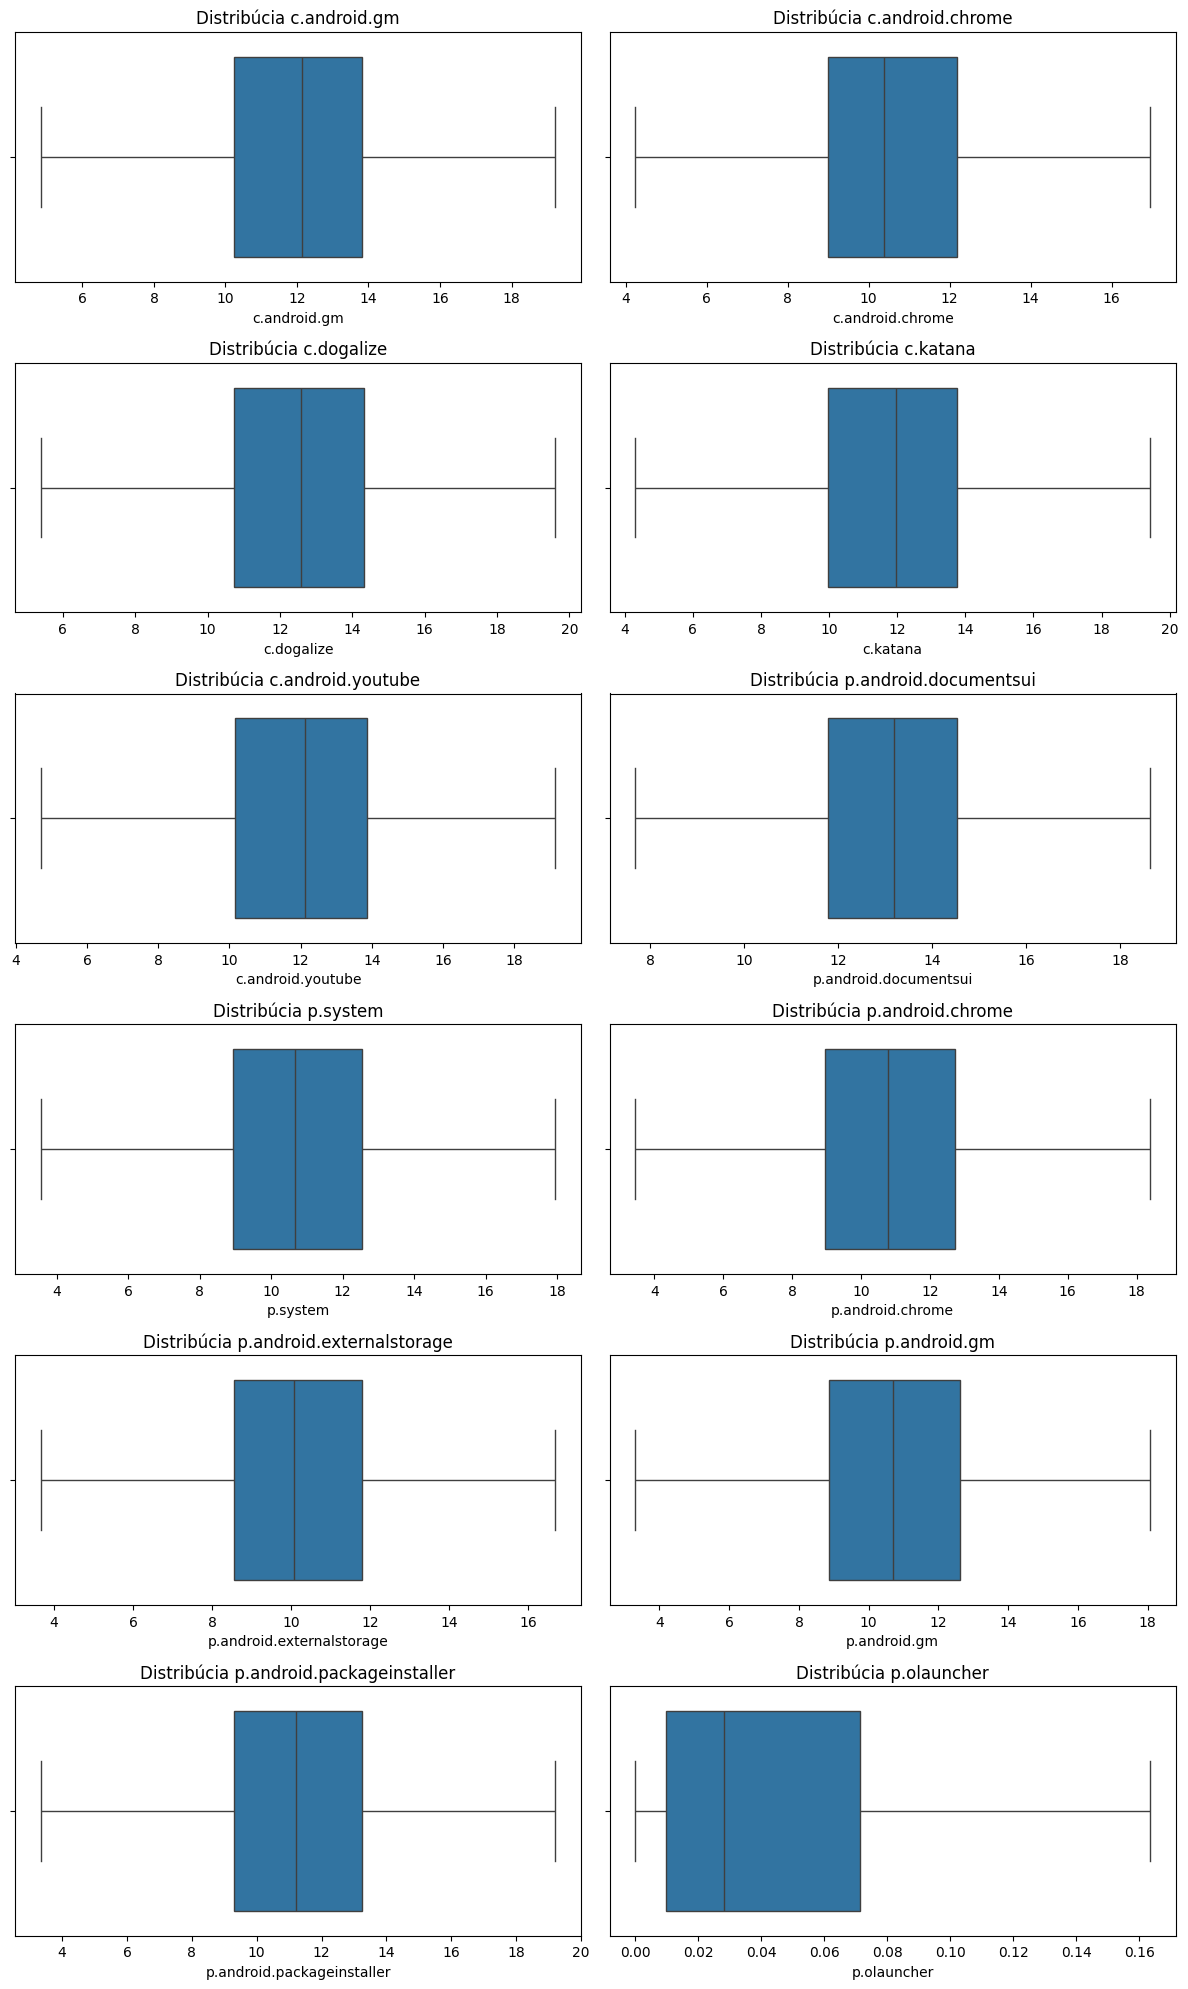

In [38]:
# Získanie počtu stĺpcov, ktoré chceme vizualizovať
num_columns = len(train_data.drop('mwra', axis=1).columns)

# Dynamické nastavenie počtu riadkov a stĺpcov pre mriežku grafov
cols = 2
rows = np.ceil(num_columns / cols).astype(int)  # zaokrúhlenie nahor

plt.figure(figsize=(12, 20))
for i, column in enumerate(train_data.drop('mwra', axis=1).columns):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(data=train_data, x=column)
    plt.title(f'Distribúcia {column}')
plt.tight_layout()
plt.show()

## 2.1.C - Data Scaling

### Data Normalization

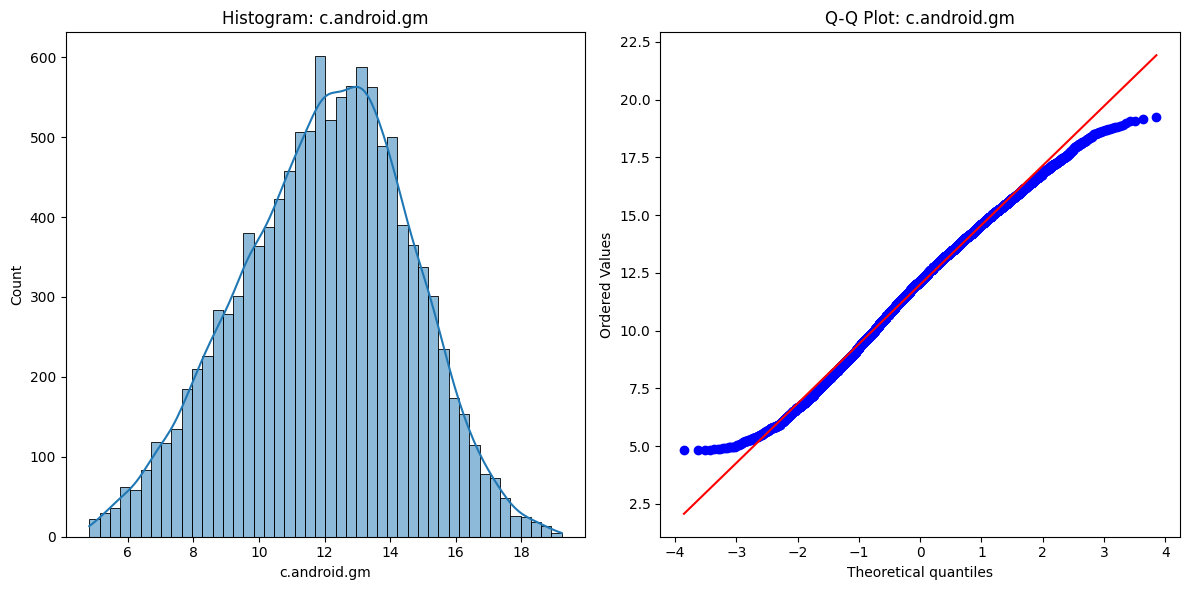

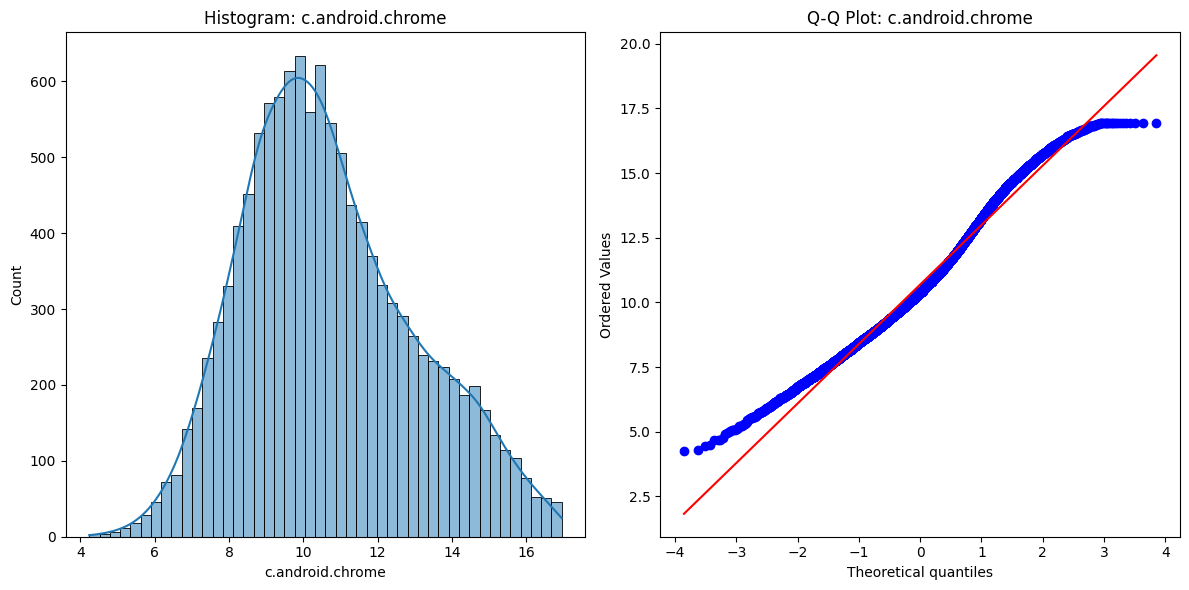

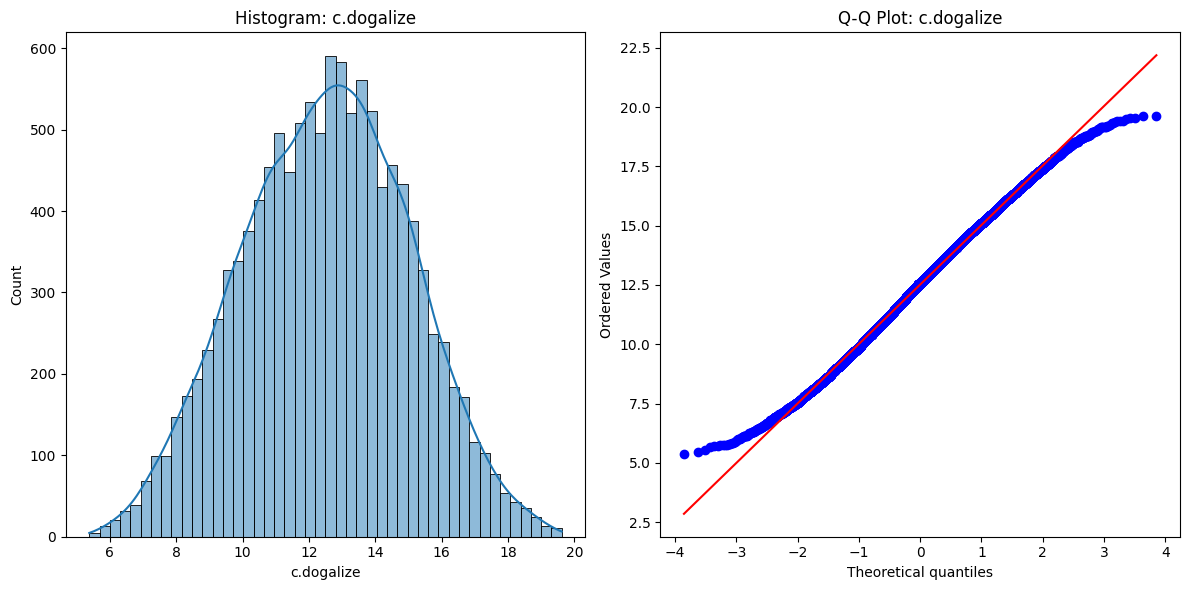

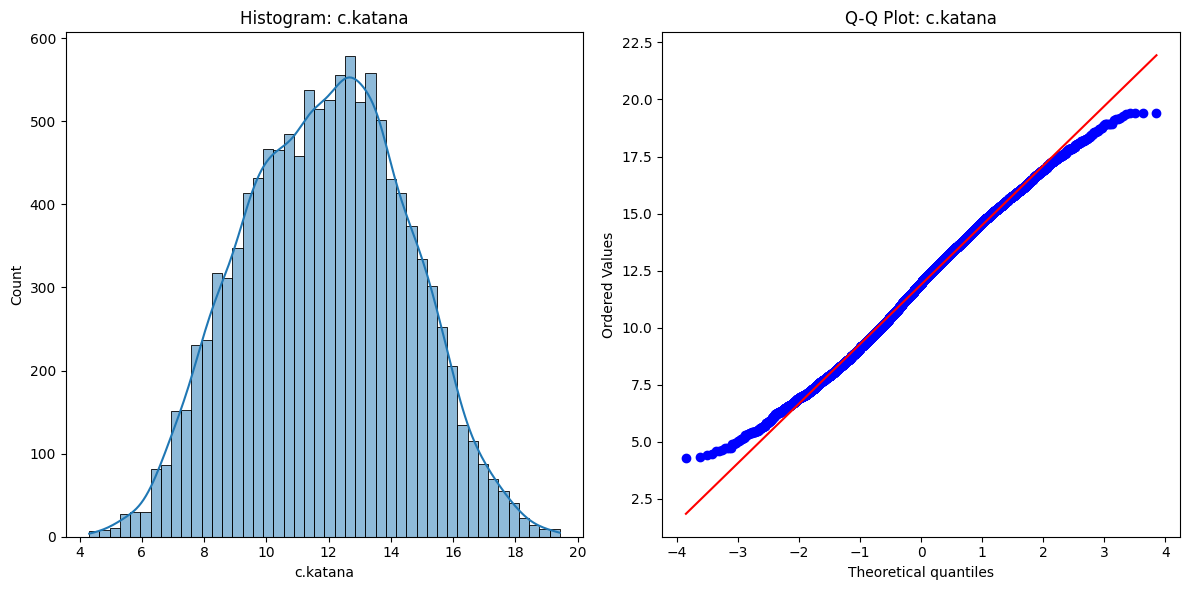

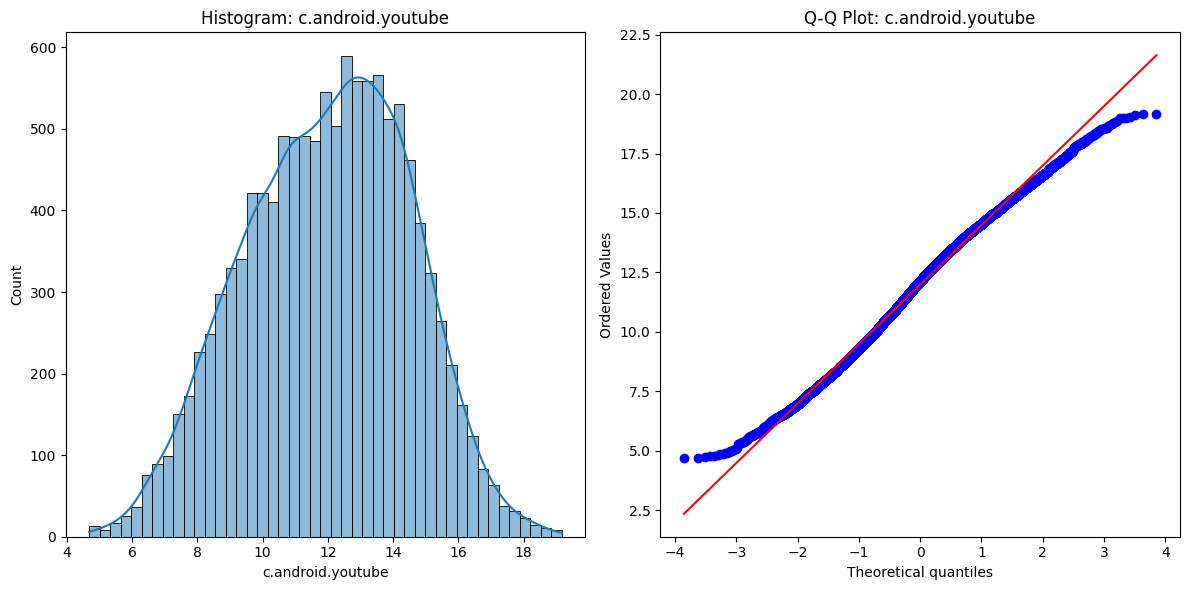

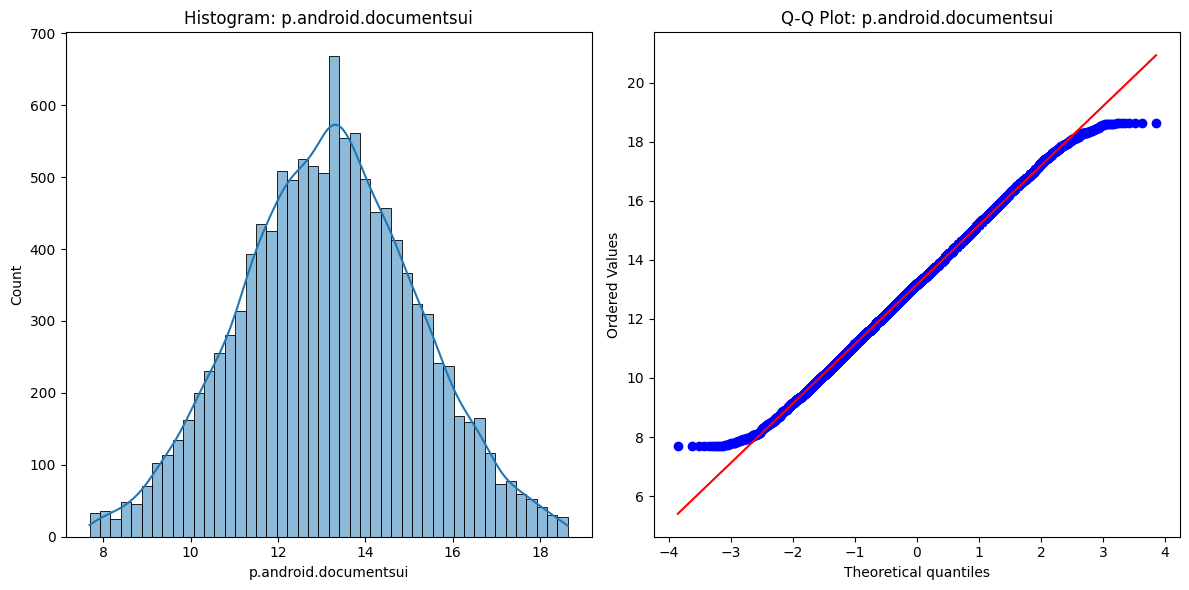

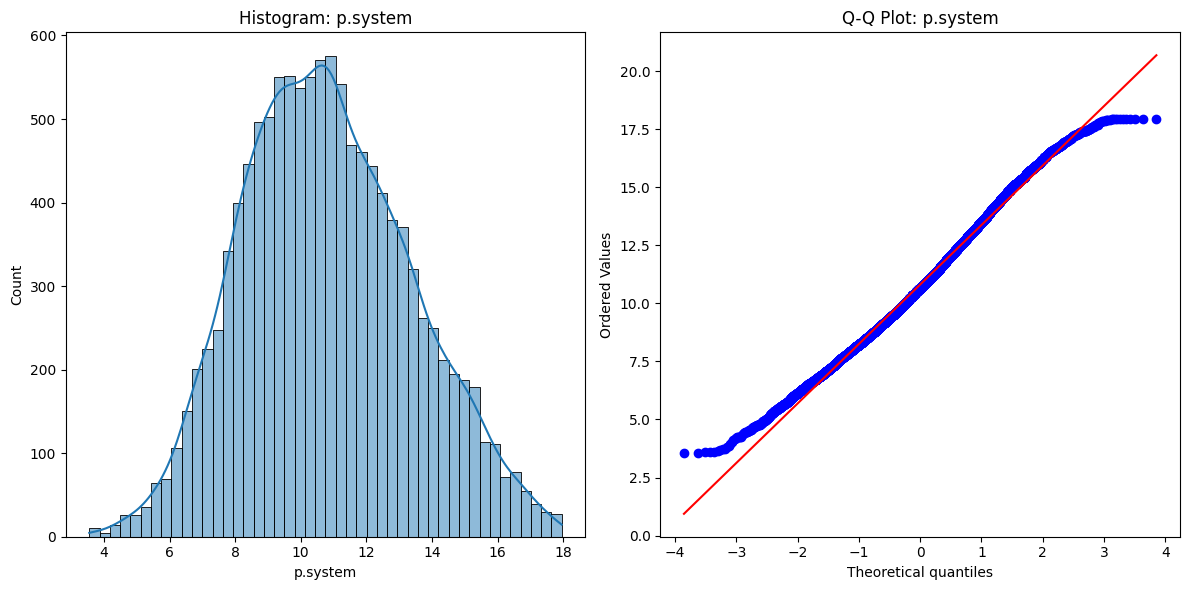

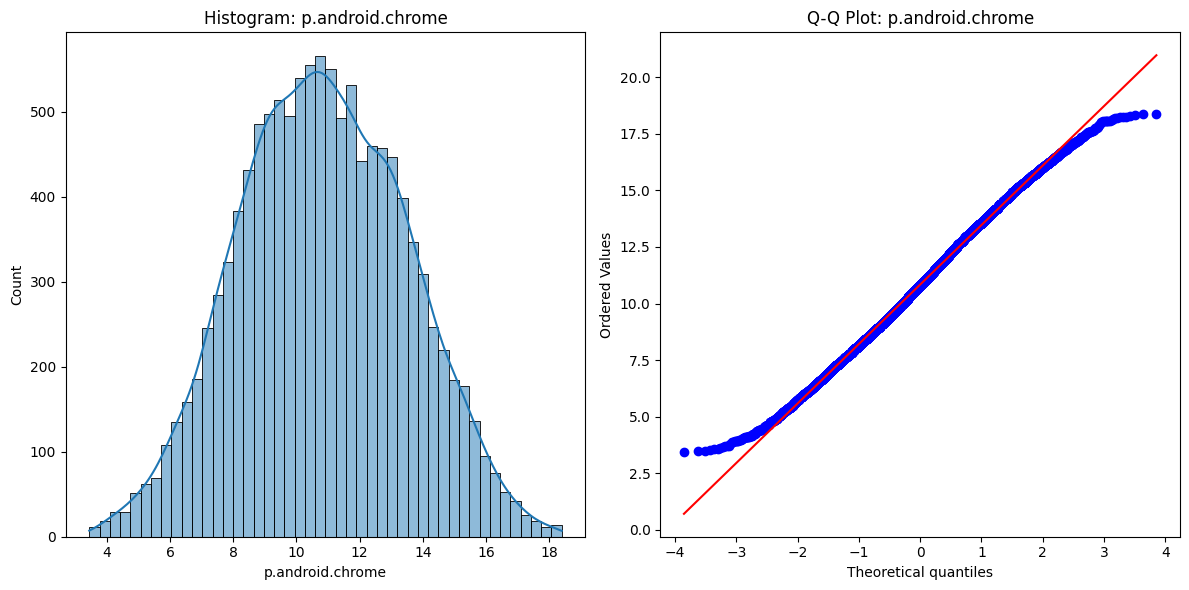

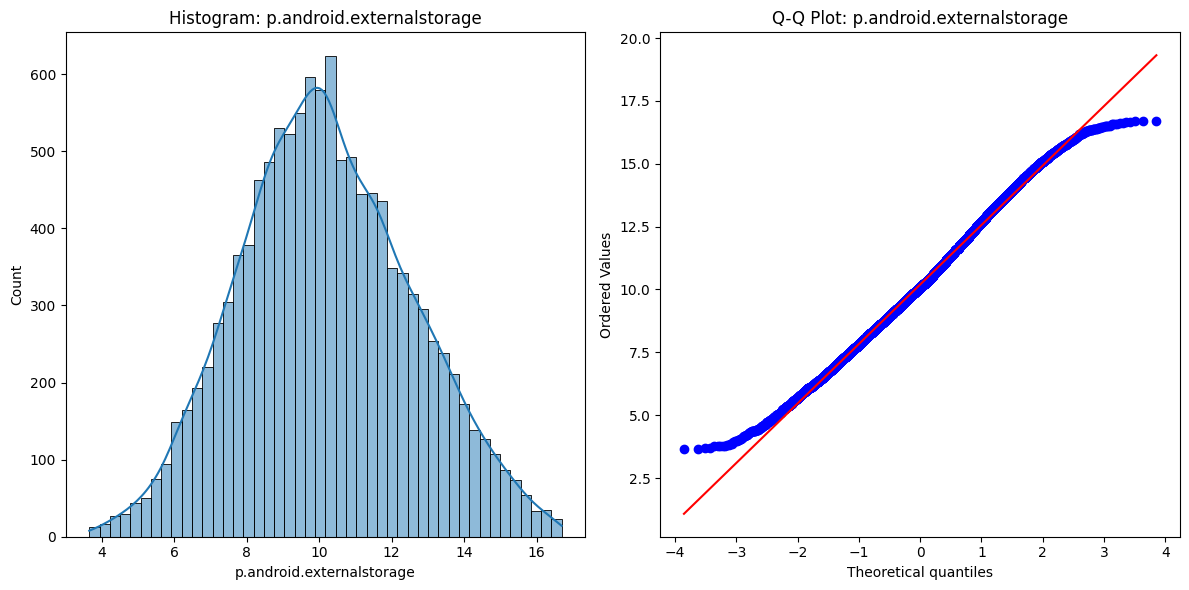

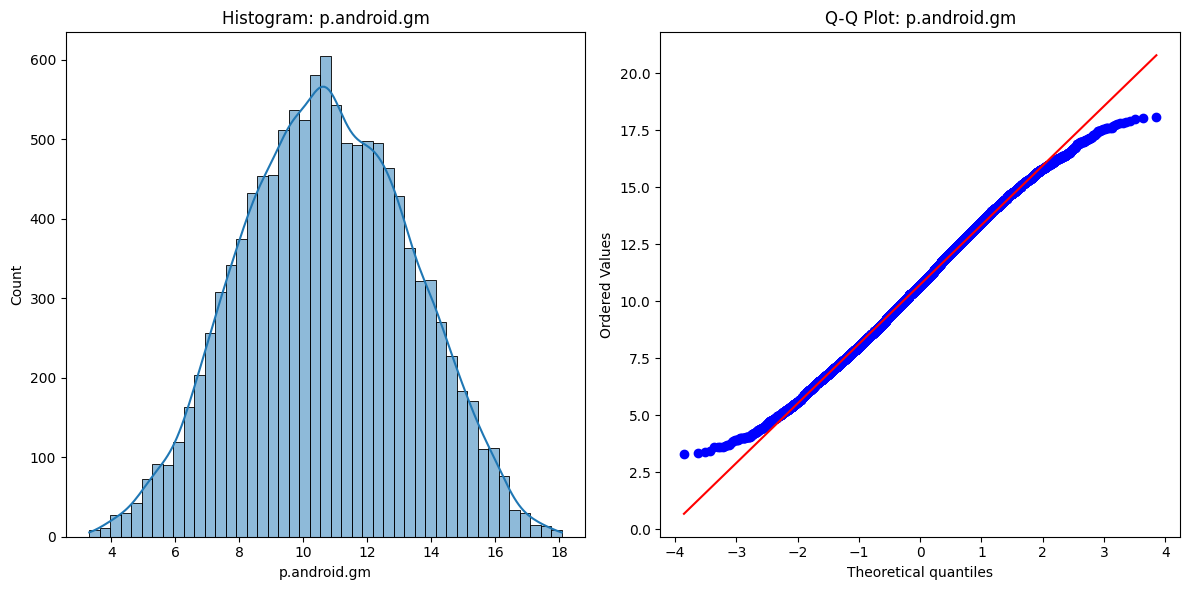

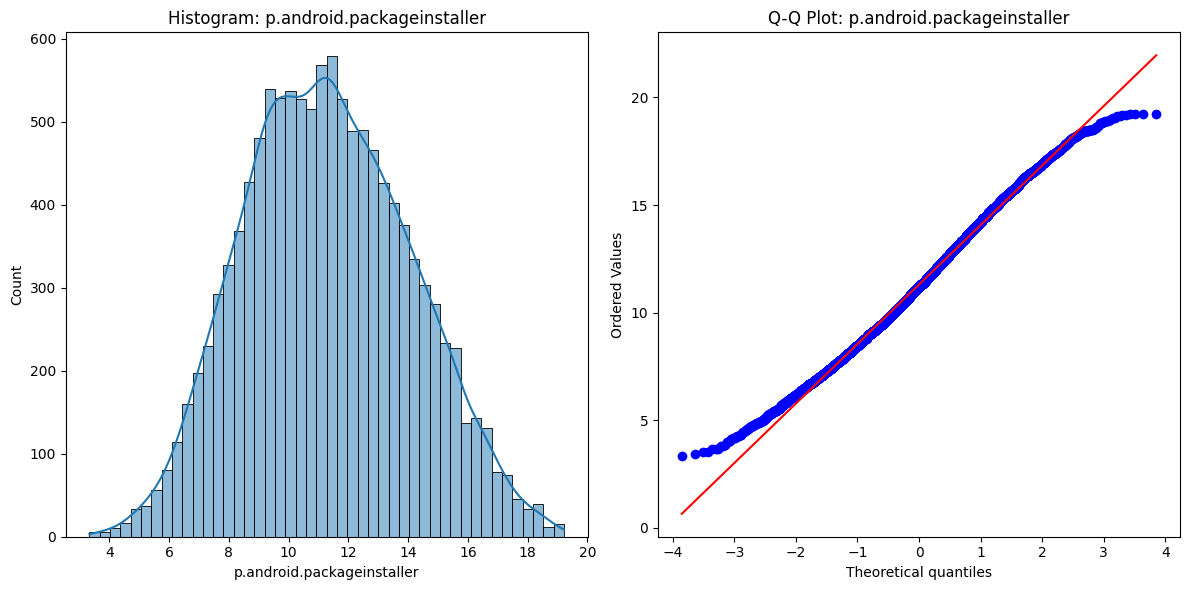

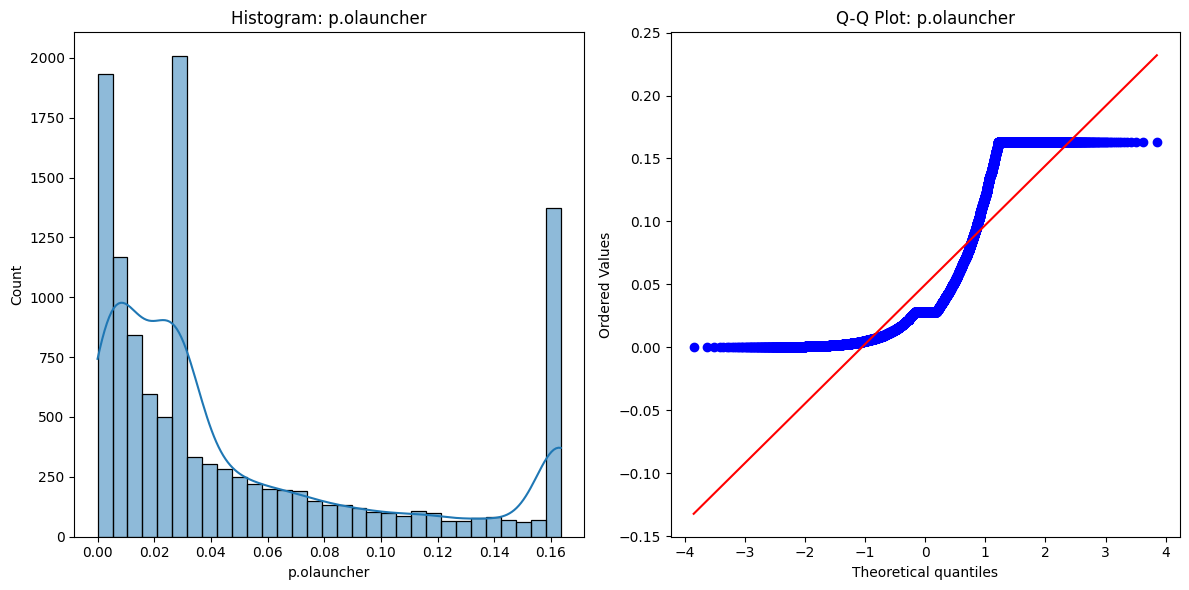

In [39]:
# Vykreslenie histogramov a Q-Q plotov
for column in train_data.drop('mwra', axis=1).columns:
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(train_data[column], kde=True)
    plt.title(f'Histogram: {column}')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(train_data[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot: {column}')

    plt.tight_layout()
    plt.show()

Z histogramov a qq plotov vidime ze data mame priblizne gaussian a p.launcher nie. 

In [40]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer

In [41]:
# Stĺpce podľa typu rozdelenia
normal_columns = ['c.android.gm', 'c.android.chrome', 'c.dogalize', 'c.katana', 
                  'c.android.youtube', 'p.android.documentsui', 'p.system', 
                  'p.android.chrome', 'p.android.externalstorage', 'p.android.gm', 
                  'p.android.packageinstaller']

skewed_columns = ['p.olauncher']


Vo všeobecnosti by sa transformácia mala vykonať pred škálovaním. Hlavný dôvod je ten, že transformácia údajov (napríklad pomocou log, Power alebo Quantile Transformácie) zmení ich distribúciu. Škálovanie následne upraví dáta do požadovaného rozsahu alebo štandardného rozloženia, čo je obzvlášť dôležité pri modeloch, ktoré sú citlivé na rozsah hodnôt.

Poradie:

1. Transformácia: Najprv vykonáme transformáciu, ktorá zlepšuje symetriu alebo normalitu dát.
2. Škálovanie: Potom aplikujeme škálovanie, ktoré prispôsobí hodnoty do rovnakého rozsahu alebo na štandardnú mierku.

#### 1. Transformácia (Quantile a Power)

In [42]:
# Quantile transformácia pre zmenu na normalovu distribuciu
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
train_data[skewed_columns] = quantile_transformer.fit_transform(train_data[skewed_columns])

In [43]:
# Power transformácia pre približne normálne rozdelené atribúty
power_transformer = PowerTransformer(method='yeo-johnson')
train_data[normal_columns] = power_transformer.fit_transform(train_data[normal_columns])

#### 2. Škálovanie (Standard a Min-Max)

Oba typy škálovania majú svoje výhody a vhodnosť použitia závisí od zvoleného modelu a typu dát. **Min-Max Scaling** je vhodný na škálovanie do pevného rozsahu (napr. 0 až 1), zatiaľ čo **Standard Scaling** je užitočný, ak potrebujeme normalizovať atribúty do symetrického rozsahu okolo 0.

In [44]:
# Standard Scaling pre normálne rozdelené atribúty
standard_scaler = StandardScaler()
train_data[normal_columns] = standard_scaler.fit_transform(train_data[normal_columns])

In [45]:
# Min-Max Scaling pre silne šikmý atribút
minmax_scaler = MinMaxScaler()
train_data[skewed_columns] = minmax_scaler.fit_transform(train_data[skewed_columns])

In [46]:
print("Standard Scaling on Power Transformed data for normal columns:")
print(train_data[normal_columns].head())

print("\nMin-Max Scaling on Log Transformed skewed column:")
print(train_data[skewed_columns].head())


Standard Scaling on Power Transformed data for normal columns:
       c.android.gm  c.android.chrome  c.dogalize  c.katana  \
9328      -1.196035          2.301022   -0.703173  0.915003   
6701       1.151811         -0.251835    2.136694  0.416367   
6262      -1.274725          0.809769   -0.008190  0.034201   
14691     -0.361116         -0.864497   -0.427110 -1.567158   
3163      -0.449809         -0.117029   -0.569458  0.434554   

       c.android.youtube  p.android.documentsui  p.system  p.android.chrome  \
9328           -0.838687              -1.642949 -1.695976         -2.154663   
6701           -1.502387               0.676350  0.513026         -0.679295   
6262           -1.512423               1.091820 -1.326632         -0.924884   
14691           0.530647               0.571926  0.766355          0.552102   
3163            0.497189               1.137384 -1.113548         -1.387703   

       p.android.externalstorage  p.android.gm  p.android.packageinstaller  
9328  

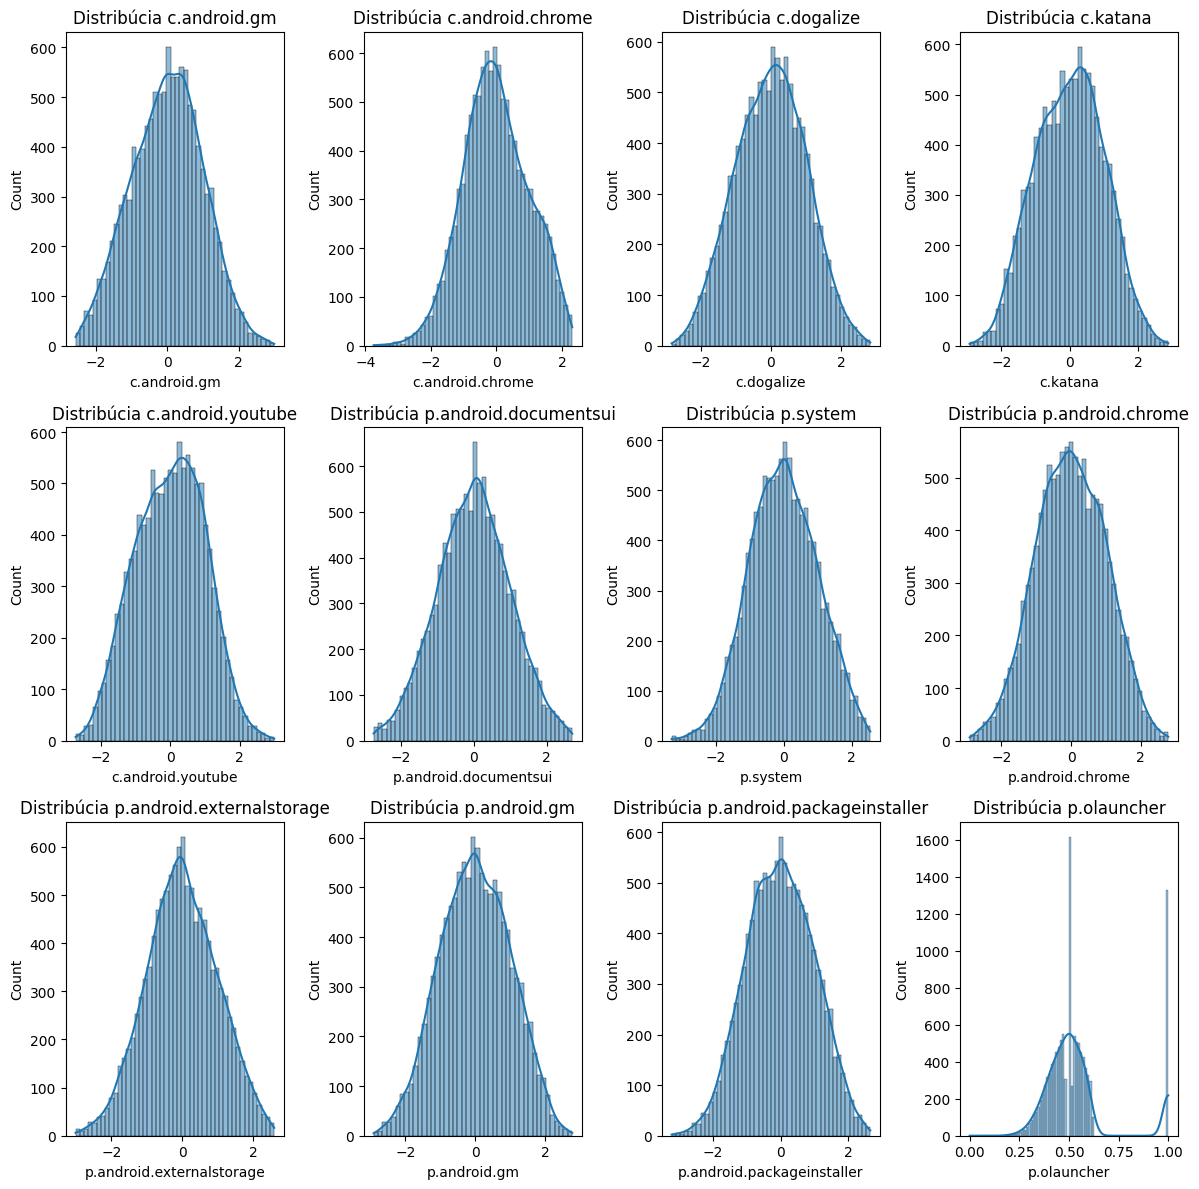

In [47]:
# Získanie počtu stĺpcov, ktoré chceme vizualizovať
num_columns = len(train_data.drop('mwra', axis=1).columns)

# Dynamické nastavenie počtu riadkov a stĺpcov pre mriežku grafov
cols = 4
rows = np.ceil(num_columns / cols).astype(int)  # zaokrúhlenie nahor

plt.figure(figsize=(12, 12))
for i, column in enumerate(train_data.drop('mwra', axis=1).columns):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(data=train_data, x=column, kde=True)
    plt.title(f'Distribúcia {column}')
plt.tight_layout()
plt.show()

## 2.1.D - Zhrnutie

1. **Poradie:** Najskôr sme aplikovali transformáciu (Quantile alebo Power) a potom škálovanie.
2. **Výber transformácií a škálovania:**
    - Standard Scaling je ideálny pre atribúty, ktoré majú približne normálne rozdelenie, zatiaľ čo Min-Max Scaling je vhodný pre atribúty s veľkým rozsahom hodnôt a šikmosťou.
    - Quantile Transformácia a Power Transformácia (Yeo-Johnson) zlepšujú symetriu a normalitu dát.

Tento prístup pripraví dáta na efektívne využitie v modeloch strojového učenia a pomôže zlepšiť stabilitu modelov, najmä pri algoritmoch citlivých na rozsah hodnôt.

# 2.2 Výber atribútov pre strojové učenie

## 2.2.A

Použil som 4 rôzne techniky na určenie dôležitosti features:

1. Korelačná analýza

    Meria lineárny vzťah medzi každým feature a cieľovou premennou<br>
    Výhody: Jednoduchá interpretácia<br>
    Nevýhody: Zachytí len lineárne vzťahy


2. Mutual Information

    Meria ako veľa informácie poskytuje feature o cieľovej premennej<br>
    Výhody: Zachytí aj nelineárne vzťahy<br>
    Nevýhody: Hodnoty sú ťažšie interpretovateľné


3. ANOVA F-value

    Testuje štatistickú významnosť rozdielov medzi skupinami<br>
    Výhody: Štatisticky podložené<br>
    Nevýhody: Predpokladá normálne rozdelenie


4. Random Forest Feature Importance

    Meria dôležitosť features na základe ich vplyvu na presnosť modelu<br>
    Výhody: Zachytí interakcie medzi features<br>
    Nevýhody: Môže byť ovplyvnená korelovanými features

1. Korelačná analýza:

Korelácia s cieľovou premennou:
c.katana                      0.546622
c.android.chrome              0.295710
c.dogalize                    0.282977
p.android.gm                  0.269831
p.olauncher                  -0.002442
p.android.documentsui        -0.003299
p.android.packageinstaller   -0.017892
c.android.gm                 -0.265350
p.android.externalstorage    -0.266437
c.android.youtube            -0.288112
p.system                     -0.534227
p.android.chrome             -0.544060
dtype: float64


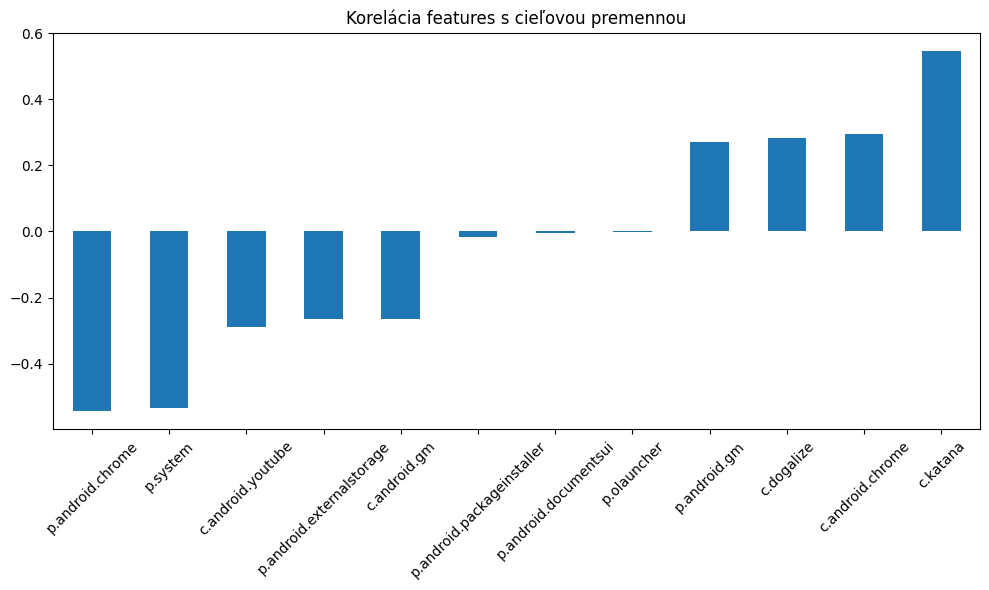


2. Mutual Information Score:
c.katana                      0.187733
p.android.chrome              0.183952
p.system                      0.169920
c.android.chrome              0.078348
p.android.externalstorage     0.054807
c.android.youtube             0.050709
c.dogalize                    0.047347
p.android.gm                  0.046745
c.android.gm                  0.042493
p.android.documentsui         0.000000
p.android.packageinstaller    0.000000
p.olauncher                   0.000000
dtype: float64


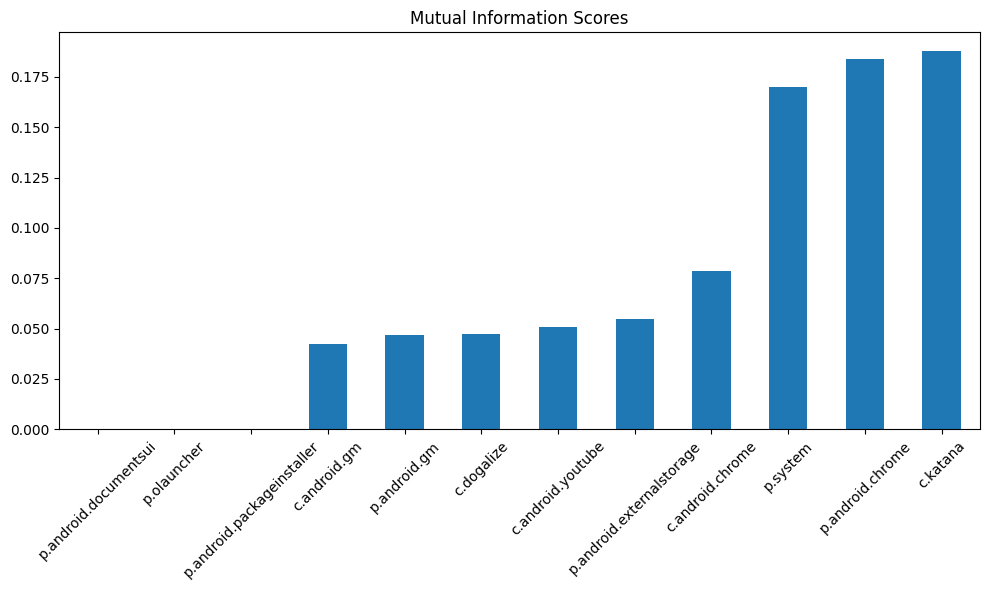


3. ANOVA F-value:
c.katana                      5072.924446
p.android.chrome              5005.554416
p.system                      4754.623021
c.android.chrome              1140.782144
c.android.youtube             1077.675620
c.dogalize                    1036.289113
p.android.gm                   934.850625
p.android.externalstorage      909.700340
c.android.gm                   901.732038
p.android.packageinstaller       3.812468
p.android.documentsui            0.129566
p.olauncher                      0.071017
dtype: float64


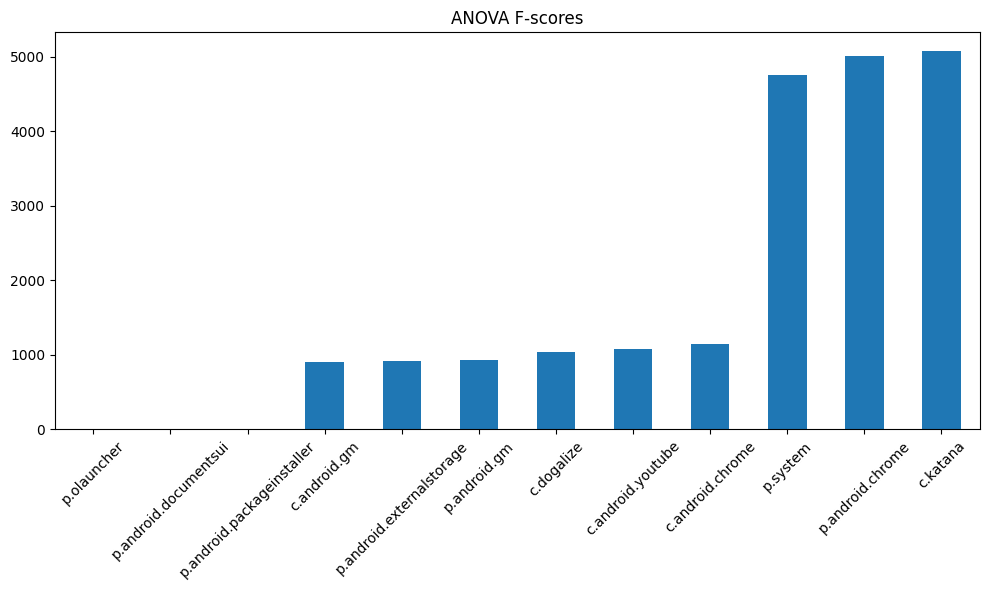


4. Random Forest Feature Importance:
p.android.chrome              0.181790
c.katana                      0.171984
p.system                      0.148052
p.android.gm                  0.097391
c.android.youtube             0.065573
c.android.chrome              0.064287
c.dogalize                    0.061369
p.android.externalstorage     0.059810
c.android.gm                  0.046933
p.android.packageinstaller    0.041131
p.android.documentsui         0.035169
p.olauncher                   0.026510
dtype: float64


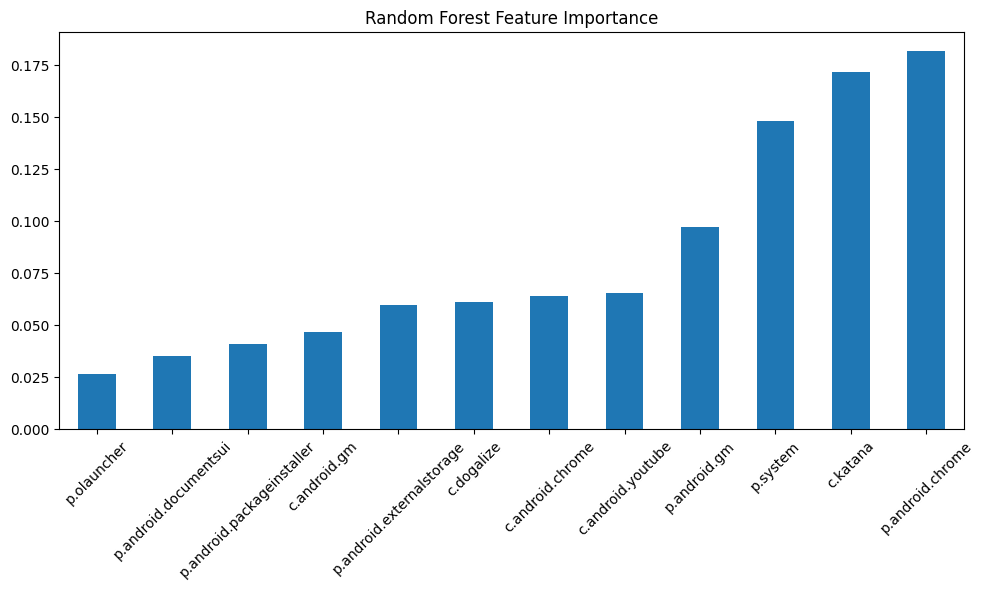

<Figure size 1200x600 with 0 Axes>

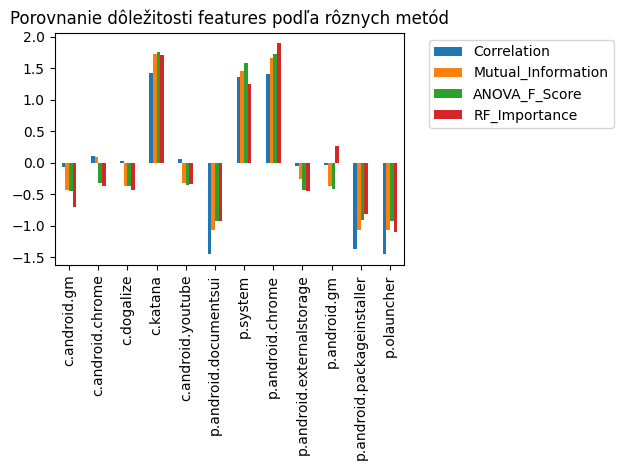


Súhrnné poradie features podľa všetkých metód:
p.android.chrome              1.676861
c.katana                      1.655968
p.system                      1.415945
c.android.chrome             -0.120406
p.android.gm                 -0.140069
c.android.youtube            -0.235599
c.dogalize                   -0.280636
p.android.externalstorage    -0.298890
c.android.gm                 -0.409320
p.android.packageinstaller   -1.041319
p.android.documentsui        -1.089837
p.olauncher                  -1.132699
dtype: float64


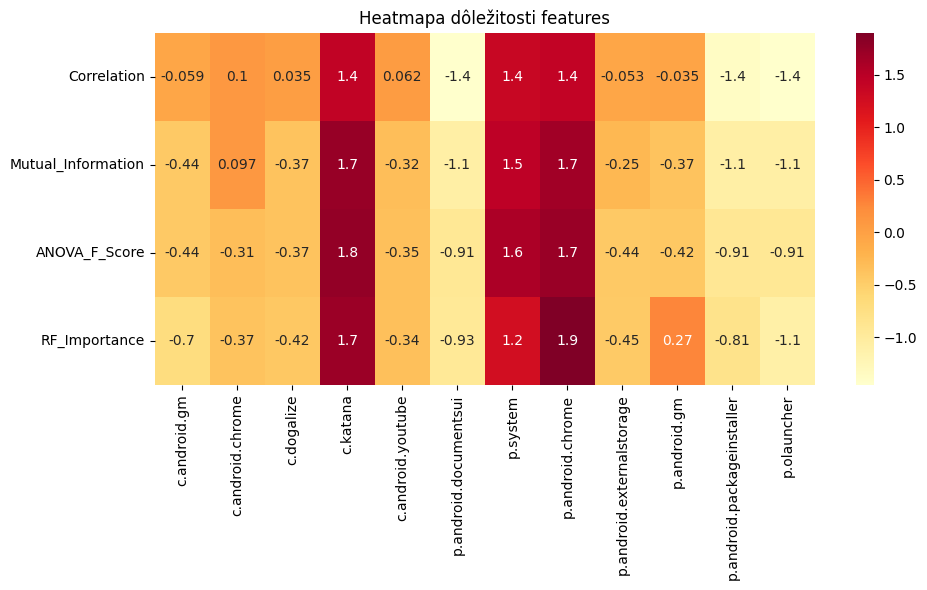

In [52]:
# Rozdelenie na features a target
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif


X = train_data.drop('mwra', axis=1)
y = train_data['mwra']

# 1. Korelačná analýza
print("1. Korelačná analýza:")
correlation_with_target = X.apply(lambda x: x.corr(y))
print("\nKorelácia s cieľovou premennou:")
print(correlation_with_target.sort_values(ascending=False))

# Vizualizácia korelácií
plt.figure(figsize=(10, 6))
correlation_with_target.sort_values().plot(kind='bar')
plt.title('Korelácia features s cieľovou premennou')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Mutual Information
print("\n2. Mutual Information Score:")
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns)
print(mi_scores.sort_values(ascending=False))

plt.figure(figsize=(10, 6))
mi_scores.sort_values().plot(kind='bar')
plt.title('Mutual Information Scores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. ANOVA F-value
print("\n3. ANOVA F-value:")
f_scores = f_classif(X, y)[0]
f_scores = pd.Series(f_scores, index=X.columns)
print(f_scores.sort_values(ascending=False))

plt.figure(figsize=(10, 6))
f_scores.sort_values().plot(kind='bar')
plt.title('ANOVA F-scores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
rf_importance = pd.Series(rf.feature_importances_, index=X.columns)
print("\n4. Random Forest Feature Importance:")
print(rf_importance.sort_values(ascending=False))

plt.figure(figsize=(10, 6))
rf_importance.sort_values().plot(kind='bar')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Porovnanie výsledkov všetkých metód
results = pd.DataFrame({
    'Correlation': abs(correlation_with_target),
    'Mutual_Information': mi_scores,
    'ANOVA_F_Score': f_scores,
    'RF_Importance': rf_importance
})

# Normalizácia hodnôt pre lepšie porovnanie
scaler = StandardScaler()
results_normalized = pd.DataFrame(
    scaler.fit_transform(results),
    columns=results.columns,
    index=results.index
)

# Vizualizácia porovnania

plt.figure(figsize=(12, 6))
results_normalized.plot(kind='bar')
plt.title('Porovnanie dôležitosti features podľa rôznych metód')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
print("\nSúhrnné poradie features podľa všetkých metód:")

# Priemerné normalizované skóre
average_importance = results_normalized.mean(axis=1).sort_values(ascending=False)
print(average_importance)

# Vytvorenie heatmapy pre lepšiu vizualizáciu
plt.figure(figsize=(10, 6))
sns.heatmap(results_normalized.T, annot=True, cmap='YlOrRd')
plt.title('Heatmapa dôležitosti features')
plt.tight_layout()
plt.show()

## 2.2.B

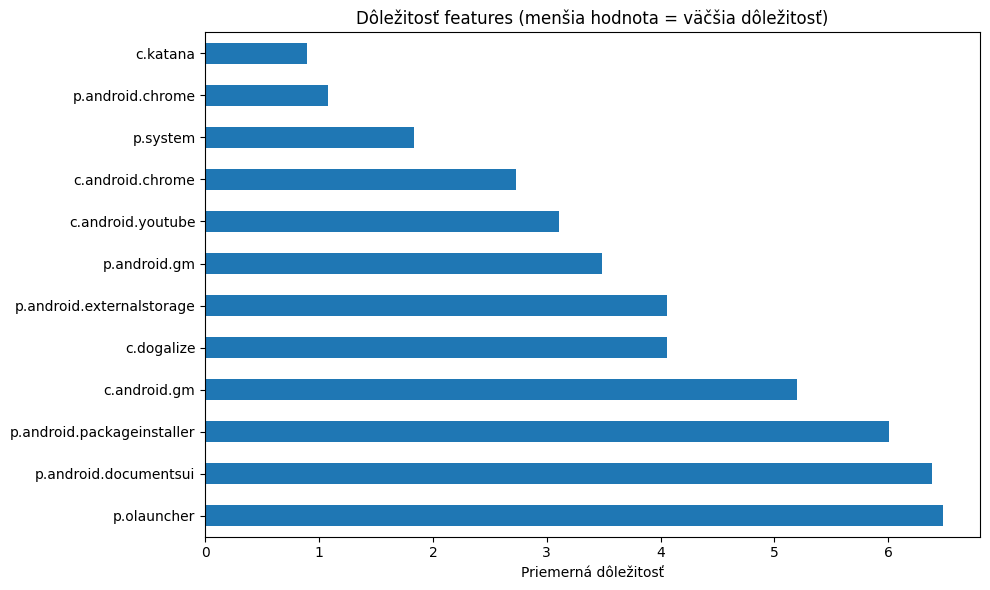

In [67]:
average_importance = results.mean(axis=1).sort_values(ascending=False)

# Vizualizácia
plt.figure(figsize=(10, 6))
average_importance.plot(kind='barh')
plt.title('Dôležitosť features (menšia hodnota = väčšia dôležitosť)')
plt.xlabel('Priemerná dôležitosť')
plt.tight_layout()
plt.show()

## 2.2.C

### 1. Korelačná analýza
Dôvod výberu: 
- Jednoduchá a rýchla metóda na identifikáciu lineárnych vzťahov
- Hodnoty od -1 do 1 sú ľahko interpretovateľné
- Umožňuje odhaliť priame aj nepriame lineárne závislosti
<br><br>
- Výhody:
   - Rýchly výpočet
   - Ľahká interpretácia
- Nevýhody:
   - Zachytí len lineárne vzťahy
   - Citlivá na outliery

### 2. Mutual Information
Dôvod výberu:
- Meria všeobecnú závislosť (aj nelineárnu)
- Vhodná pre klasifikačné úlohy
- Nezávislá na škálovaní dát
<br><br>
- Výhody:
   - Zachytí aj nelineárne vzťahy
   - Robustná voči outlierom  
- Nevýhody:
   - Náročnejšia interpretácia hodnôt
   - Výpočtovo náročnejšia

### 3. ANOVA F-value
Dôvod výberu:
- Štatisticky podložená metóda
- Testuje rozdiely medzi skupinami
- Vhodná pre klasifikačné úlohy
<br><br>
- Výhody:
   - Štatisticky robustná
- Nevýhody:
   - Predpokladá normálne rozdelenie
   - Citlivá na veľkosť vzorky

### 4. Random Forest Feature Importance
Dôvod výberu:
- Založená na reálnom modeli strojového učenia
- Berie do úvahy interakcie medzi premennými
- Robustná voči outlierom a chýbajúcim hodnotám
<br><br>
- Výhody:
   - Zachytí komplexné vzťahy
   - Priamo súvisí s predikčnou silou
- Nevýhody:
   - Výpočtovo náročná
   - Môže byť ovplyvnená korelovanými features

### Normalizácia a porovnanie
Dôvod použitia StandardScaler:
- Rôzne metriky majú rôzne škály
- Normalizácia umožňuje priame porovnanie
- Štandardizované skóre sú ľahšie porovnateľné

Dôvod použitia viacerých vizualizácií:
1. Bar plots pre jednotlivé metódy:
   - Prehľadné zobrazenie poradia
   - Ľahko čitateľné jednotlivé hodnoty

2. Heatmapa:
   - Kompaktné zobrazenie všetkých metód
   - Farebné kódovanie pre rýchlu orientáciu
   - Možnosť vidieť vzory medzi metódami

3. Priemerná dôležitosť:
   - Sumarizácia všetkých metód
   - Konečné poradie features
   - Jednoduchá interpretácia

# 2.3 Replikovateľnosť predspracovania

## 2.3.A

## 2.3.B

# Záver

In [49]:
train_data.head()

,mwra,c.android.gm,c.android.chrome,c.dogalize,c.katana,c.android.youtube,p.android.documentsui,p.system,p.android.chrome,p.android.externalstorage,p.android.gm,p.android.packageinstaller,p.olauncher
9328,1.0,-1.196035,2.301022,-0.703173,0.915003,-0.838687,-1.642949,-1.695976,-2.154663,-0.424138,-0.352913,-0.542399,0.348724
6701,1.0,1.151811,-0.251835,2.136694,0.416367,-1.502387,0.676350,0.513026,-0.679295,0.230764,0.595074,2.207195,0.613679
6262,1.0,-1.274725,0.809769,-0.008190,0.034201,-1.512423,1.091820,-1.326632,-0.924884,-1.121591,-0.060092,-0.854018,1.000000
14691,0.0,-0.361116,-0.864497,-0.427110,-1.567158,0.530647,0.571926,0.766355,0.552102,1.193831,0.009804,-1.008849,0.599145
3163,1.0,-0.449809,-0.117029,-0.569458,0.434554,0.497189,1.137384,-1.113548,-1.387703,-0.184408,1.295555,1.307551,0.500483


In [50]:
test_data.head()

,mwra,c.android.gm,c.android.chrome,c.dogalize,c.katana,c.android.youtube,p.android.documentsui,p.system,p.android.chrome,p.android.externalstorage,p.android.gm,p.android.packageinstaller,p.olauncher
9699,0.0,12.79610,9.54881,13.37844,8.88960,11.73873,14.22378,15.33243,10.42048,14.44611,9.06572,9.27204,0.114540
3495,1.0,14.36603,11.02481,7.15998,14.90366,16.88732,16.04924,8.79188,7.15135,6.53138,14.50156,12.38939,0.027995
14101,1.0,8.11004,12.94767,14.46907,13.21636,9.68932,14.01122,13.28173,9.11917,8.73867,5.53707,8.36017,0.092640
1911,0.0,14.70750,9.64259,10.11273,6.23854,12.75294,14.80452,13.27571,13.41306,8.78915,8.67653,15.74338,0.204660
6244,1.0,5.59109,13.96885,13.56568,12.02378,10.18199,14.98452,9.03149,6.61945,9.26161,12.27947,10.01778,0.244930


In [51]:
train_data.to_csv('dataset/train_transformed.csv', sep='\t', index=False, encoding='utf-8')
test_data.to_csv('dataset/test_data.csv', sep='\t', index=False, encoding='utf-8')